In [11]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv("/Users/calvi/Downloads/Airbnb_Open_Data.csv")

/var/folders/8_/_mkv7dtj7hvfvhvj31qsy35h0000gn/T/ipykernel_27693/3315724145.py:12: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/calvi/Downloads/Airbnb_Open_Data.csv")


In [12]:
# Dropping all categorical / text columns since they arent really important and dont need to be encoded
drop_cols = [
    "id", "NAME", "host id", "host name", "neighbourhood group", "neighbourhood",
    "country", "country code", "instant_bookable", "cancellation_policy",
    "room type", "host_identity_verified", "house_rules", "license",
    "service fee", "last review"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")


In [13]:
# Clean price column so no dollar sign
def clean_money(x):
    if pd.isna(x): return np.nan
    s = re.sub(r"[^0-9.]", "", str(x))
    return float(s) if s else np.nan

df["price"] = df["price"].apply(clean_money)
df = df[(df["price"].notna()) & (df["price"] > 0)].copy()

# Trim outliers (1st–99th percentile)
p1, p99 = df["price"].quantile([0.01, 0.99])
df = df[(df["price"] >= p1) & (df["price"] <= p99)].copy()

# Log transform price so its not right skewed by a few high price listings
df["log_price"] = np.log1p(df["price"])

# Convert numeric columns
num_cols = [
    "Construction year", "minimum nights", "number of reviews", "reviews per month",
    "review rate number", "calculated host listings count", "availability 365",
    "lat", "long"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# making some features I thought would be useful
df["review_ratio"] = df["reviews per month"] / (df["calculated host listings count"] + 1)
df["age_factor"] = 2025 - df["Construction year"]

# Clean infs / NaNs
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [14]:
features = [
    "lat", "long",
    "minimum nights", "number of reviews", "reviews per month",
    "review rate number", "calculated host listings count",
    "availability 365", "Construction year",
    "review_ratio", "age_factor"
]
features = [f for f in features if f in df.columns]

X = df[features]
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
lin = LinearRegression().fit(X_train_scaled, y_train)
pred1 = lin.predict(X_test_scaled)

rmse1 = root_mean_squared_error(np.expm1(y_test), np.expm1(pred1))
mae1  = mean_absolute_error(np.expm1(y_test), np.expm1(pred1))
r2_1  = r2_score(y_test, pred1)

print({"Linear_RMSE": round(rmse1,2), "Linear_MAE": round(mae1,2), "Linear_R2": round(r2_1,3)})

{'Linear_RMSE': 345.96, 'Linear_MAE': 294.51, 'Linear_R2': -0.0}


In [16]:
ridge = Ridge(alpha=1.0, random_state=42).fit(X_train_scaled, y_train)
pred2 = ridge.predict(X_test_scaled)

rmse2 = root_mean_squared_error(np.expm1(y_test), np.expm1(pred2))
mae2  = mean_absolute_error(np.expm1(y_test), np.expm1(pred2))
r2_2  = r2_score(y_test, pred2)

print({"Ridge_RMSE": round(rmse2,2), "Ridge_MAE": round(mae2,2), "Ridge_R2": round(r2_2,3)})

{'Ridge_RMSE': 345.96, 'Ridge_MAE': 294.51, 'Ridge_R2': -0.0}


In [17]:
gb = GradientBoostingRegressor(
    n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42
).fit(X_train, y_train)  

pred3 = gb.predict(X_test)

rmse3 = root_mean_squared_error(np.expm1(y_test), np.expm1(pred3))
mae3  = mean_absolute_error(np.expm1(y_test), np.expm1(pred3))
r2_3  = r2_score(y_test, pred3)

print({"GB_RMSE": round(rmse3,2), "GB_MAE": round(mae3,2), "GB_R2": round(r2_3,3)})

{'GB_RMSE': 344.67, 'GB_MAE': 293.16, 'GB_R2': 0.007}


In [18]:
results = pd.DataFrame([
    {"Model": "Linear", "RMSE": round(rmse1,2), "MAE": round(mae1,2), "R2": round(r2_1,3)},
    {"Model": "Ridge",  "RMSE": round(rmse2,2), "MAE": round(mae2,2), "R2": round(r2_2,3)},
    {"Model": "GB",     "RMSE": round(rmse3,2), "MAE": round(mae3,2), "R2": round(r2_3,3)},
])
results


,Model,RMSE,MAE,R2
0,Linear,345.96,294.51,-0.000
1,Ridge,345.96,294.51,-0.000
2,GB,344.67,293.16,0.007


                           Feature  Importance
1                             long    0.234168
0                              lat    0.196766
9                     review_ratio    0.177798
7                 availability 365    0.092000
3                number of reviews    0.080806
4                reviews per month    0.070375
2                   minimum nights    0.035994
8                Construction year    0.034414
10                      age_factor    0.027619
6   calculated host listings count    0.027011
5               review rate number    0.023048


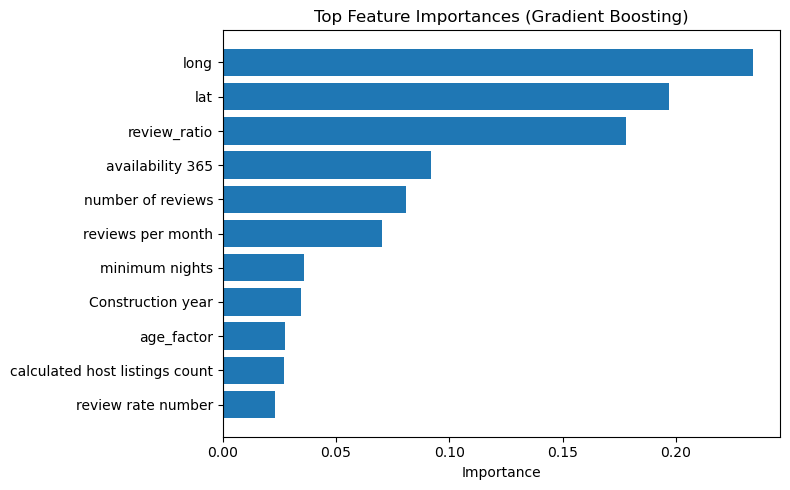

In [19]:
gb_importance = pd.DataFrame({
    "Feature": features,
    "Importance": gb.feature_importances_
}).sort_values("Importance", ascending=False)

print(gb_importance.head(20))

# 2) Quick plot (top 15)
top = gb_importance.head(15)
plt.figure(figsize=(8,5))
plt.barh(top["Feature"][::-1], top["Importance"][::-1])
plt.title("Top Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()